In [5]:
!pip install tensorflow==2.10.0 opencv-python matplotlib

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'd:\\ide\\miniconda3\\lib\\site-packages\\numpy-1.23.5.dist-info\\METADATA'




     -------------------------------------- 455.9/455.9 MB 3.7 MB/s eta 0:00:00
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)


In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
#Avoid out of memories by setting GPU memory consumption
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.__version__
len(tf.config.list_physical_devices('GPU'))>0

False

In [8]:
tf.__version__
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(tf.config.list_physical_devices('GPU'))>0

False

In [4]:
#Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [5]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
import uuid

In [22]:
uuid.uuid1()

UUID('bc791e10-eb5b-11ed-9395-e45e37a80e3e')

In [1]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #Cut down frame
    frame = frame[225:225+250, 200:200+250, :]
    
    frame = cv2.flip(frame, 1)
    
    #Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #Create unique file patch
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor name
        cv2.imwrite(imgname, frame)
    
    #Collect positives:
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #Create unique file patch
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out positive name
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)#Show image back to screen
    
    if cv2.waitKey(1) & 0XFF == ord('q'):#Break condition
        break
cap.release()
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()

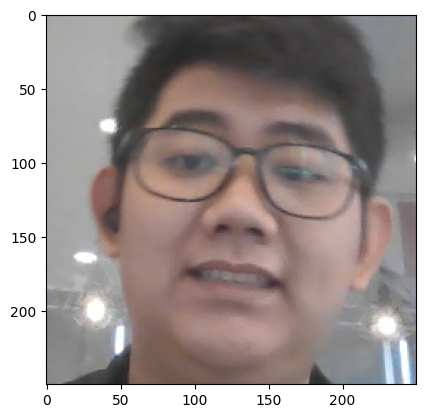

In [10]:
#Read image from file path
byte_img = tf.io.read_file('data\\anchor\\b5525821-da8d-11ed-bc20-e45e37a80e3e.jpg')
    
#Load in the image 
img = tf.io.decode_jpeg(byte_img)
plt.imshow(img)

In [11]:
def preprocess(file_path):
    #Read image from file path
    byte_img = tf.io.read_file(file_path)
    
    #Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    #Preprocessing steps
    img = tf.image.resize(img, (100, 100))
    
    #Scale img to be between 0 and 1
    img = img/255.0
    return img

In [12]:
img = preprocess('data\\anchor\\b5525821-da8d-11ed-bc20-e45e37a80e3e.jpg')

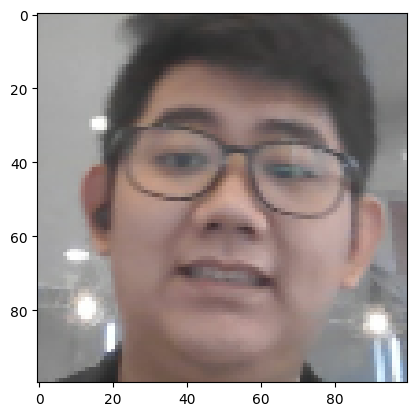

In [13]:
plt.imshow(img)

In [14]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [15]:
samples = data.as_numpy_iterator()

In [16]:
example = samples.next()

In [17]:
def preprocess_twin (input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*example)

In [19]:
res[2]

1.0

In [20]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
train_samples = train_data.as_numpy_iterator()

In [24]:
train_sample = train_samples.next()

In [25]:
len(train_sample[2])

16

In [26]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [27]:
inp = Input(shape=(100, 100, 3), name='abc')
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'abc')>

In [29]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)

In [30]:
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

In [31]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [32]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    #First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    #Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    #Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    #Final block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 128)       26

In [35]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

l1(anchor_embedding, validation_embedding)

In [37]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [38]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [39]:
siamese_layer = L1Dist()

In [40]:
distances = siamese_layer(inp_embedding, val_embedding)

In [41]:
classifier = Dense(1, activation='sigmoid')(distances)

In [42]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [44]:
def make_siamese_model():
    
    # Anchor image
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    #Validation image
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs = classifier, name='SiameseNetwork')

In [45]:
siamese_model = make_siamese_model()

In [46]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [47]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [48]:
opt = tf.keras.optimizers.Adam(1e-4) #0.0001

In [49]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [50]:
test_batch = train_data.as_numpy_iterator()

In [51]:
batch_1 = test_batch.next()

In [52]:
X = batch_1[:2]

In [53]:
y = batch_1[2]

In [54]:
y

array([0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [55]:
@tf.function
def train_step(batch):
    
    # Record all of operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        #Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [56]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Train step
            train_step(batch)
            progbar.update(idx+1)
            
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [57]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 9/27 [=========>....................] - ETA: 8:22